# [ DistillBERT vs LORA - with Low Rank Adaptation ]

st125214 - Maung Maung Kyi Tha

Exploring the comparison between Odd Layer and Even Layer Student Training Models and LoRA (Low-Rank Adaptation) on a distillation task using BERT.

In [1]:
# Environment Setup

# General Maintenance
import numpy as np  
#import random, math, time
#import re, os

# For loading the HuggingFace dataset
import datasets
from datasets import load_dataset
from datasets import DatasetDict

# For tokenization and data collation
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import get_scheduler
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel, BertConfig

# For training the model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# For evaluation of models
import evaluate

# For plotting accuracy and loss graphs
import matplotlib.pyplot as plt

In [2]:
# setting device to GPU cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")
print("Available GPUs:", torch.cuda.device_count())
print("Using Cuda Version :", torch.version.cuda)
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# Seet my seed for consistent results
SEED = 75
torch.manual_seed(SEED)

# Making sure we get the same results on each run
torch.backends.cudnn.deterministic = True

# Disable user warnings for neater output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Using cuda
Available GPUs: 1
Using Cuda Version : 11.8
GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU


### 1. Source Discovery for Hate Speech/Toxic Comment Dataset
I use "thefrankhsu/hate_speech_twitter" hate speech classification dataset, which contains samples form twitter tweets.

The dataset comprises three key features: tweets, labels (with hate speech denoted as 1 and non-hate speech as 0), and categories.

Source : https://huggingface.co/datasets/thefrankhsu/hate_speech_twitter


In [3]:
dataset = load_dataset("thefrankhsu/hate_speech_twitter")
print(dataset)
print(dataset['train'][0])

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'categories'],
        num_rows: 5679
    })
    test: Dataset({
        features: ['tweet', 'label', 'categories'],
        num_rows: 1000
    })
})
{'tweet': 'krazy i dont always get drunk and pass out but when i do when did they start making colored duct tape', 'label': 0, 'categories': None}


In [4]:
print(dataset["train"].column_names)

['tweet', 'label', 'categories']


In [5]:
# Round the training data to 5000 samples for better performance and calculation

dataset = DatasetDict({
    "train": dataset["train"].select(range(5000)),
    "test": dataset["test"]
})

In [6]:
# define label list
#label_list = ["hate_speech", "offensive_language", "neither"]
label_list = ["non_hate_speech", "hate_speech", "neither"]

label2id = {label: idx for idx, label in enumerate(label_list)}
id2label = {idx: label for label, idx in label2id.items()}

In [7]:
# Assign feature key
task_to_keys = {"hatexplain": "tweet"}
task_name = "hatexplain"
sentence_key = task_to_keys[task_name]

In [8]:
# Print dataset overview
print(dataset)
print("Example:", dataset["train"][0][sentence_key])
print("Label2ID:", label2id)
print("ID2Label:", id2label)

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'categories'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['tweet', 'label', 'categories'],
        num_rows: 1000
    })
})
Example: krazy i dont always get drunk and pass out but when i do when did they start making colored duct tape
Label2ID: {'non_hate_speech': 0, 'hate_speech': 1, 'neither': 2}
ID2Label: {0: 'non_hate_speech', 1: 'hate_speech', 2: 'neither'}


#### Tokenize the Dataset

In [9]:
# Load BERT tokenizer
teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

# Load Teacher Model (BERT)
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define a function to tokenize the dataset
def tokenize_fn(batch):
    return tokenizer(batch["tweet"], max_length=128, 
                     padding="max_length", truncation=True)

# Tokenize the dataset
encoded_dataset = dataset.map(tokenize_fn, batched=True)

# Remove unnecessary columns from the dataset
encoded_dataset = encoded_dataset.remove_columns(["categories", "tweet"])

# Rename "label" column to "labels" for PyTorch compatibility
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# Set dataset format for PyTorch
encoded_dataset.set_format("torch")

# Print an example tokenized input
print(encoded_dataset["train"][0]["input_ids"])
print(tokenizer.decode(encoded_dataset["train"][0]["input_ids"]))

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

tensor([  101,  1047, 20409,  2100,  1045,  2123,  2102,  2467,  2131,  7144,
         1998,  3413,  2041,  2021,  2043,  1045,  2079,  2043,  2106,  2027,
         2707,  2437,  6910, 23245,  6823,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

#### Preparing the Dataloader

In [11]:
# Data Collator (Handles Dynamic Padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
# Define dataset size for training efficiency and resource constraints
small_train_dataset = encoded_dataset["train"].shuffle(seed=75).select(range(5000))  # 5000 samples
small_eval_dataset = encoded_dataset["train"].shuffle(seed=75).select(range(1000))   # 1000 samples 
small_test_dataset = encoded_dataset["train"].shuffle(seed=75).select(range(1000))   # 1000 samples 

In [13]:
# Create Dataloaders for training, evaluation, and testing
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator
)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator
)

In [14]:
# Check first batch
for batch in train_dataloader:
    break

batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 2. Model Training for Even and Odds Layers

In [15]:
# Get teacher configuration as a dictionary
configuration = teacher_model.config.to_dict()

# Half the number of hidden layers (6 instead of 12)
configuration["num_hidden_layers"] = 6

# Convert dictionary to student configuration
configuration = BertConfig.from_dict(configuration)

In [16]:
# Create uninitialized student models for Odd & Even Layer Training
student_model_odd = type(teacher_model)(configuration)
student_model_even = type(teacher_model)(configuration)

In [17]:
# checking the model
student_model_even

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

#### Define Functions

In [18]:
# Function for distilling BERT weights for Odd/Even Layer Training

def distill_bert_weights(teacher, student, layer_type="odd"):

    """
    Copies weights from the teacher model to the student model.
    Only copies odd or even layers as specified by `layer_type`.

    layer_type: 'odd' -> {1,3,5,7,9,11} mapped to student {0,1,2,3,4,5}
                'even' -> {2,4,6,8,10,12} mapped to student {0,1,2,3,4,5}
    """

    if isinstance(teacher, BertModel) or isinstance(teacher, BertPreTrainedModel):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, layer_type)

    elif hasattr(teacher, "encoder") and hasattr(student, "encoder"):
        teacher_encoding_layers = list(teacher.encoder.layer)  # 12 layers
        student_encoding_layers = list(student.encoder.layer)  # 6 layers

        if layer_type == "odd":
            selected_layers = [teacher_encoding_layers[i] for i in range(12) if i % 2 == 0]  # {1,3,5,7,9,11}
        else:  # Even layers
            selected_layers = [teacher_encoding_layers[i] for i in range(12) if i % 2 == 1]  # {2,4,6,8,10,12}

        # Ensure correct mapping to student layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(selected_layers[i].state_dict())

    elif hasattr(teacher, "pooler") and hasattr(student, "pooler"):
        student.pooler.load_state_dict(teacher.pooler.state_dict())  # Copy pooler weights if present

    return student

    return student

In [19]:
# Apply distillation: Create student models from Odd and Even layers
student_model_odd = distill_bert_weights(teacher_model, student_model_odd, "odd")
student_model_even = distill_bert_weights(teacher_model, student_model_even, "even")

# Move models to device
student_model_odd = student_model_odd.to(device)
student_model_even = student_model_even.to(device)
teacher_model = teacher_model.to(device)

In [20]:
# Print model parameter counts
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Teacher Model parameters:", count_parameters(teacher_model))
print("Odd Student Model parameters:", count_parameters(student_model_odd))
print("Even Student model parameters:", count_parameters(student_model_even))

# Percentage size reduction
print(f"Odd Student Model Size: {count_parameters(student_model_odd)/count_parameters(teacher_model) * 100:.2f}%")
print(f"Even Student Model Size: {count_parameters(student_model_even)/count_parameters(teacher_model) * 100:.2f}%")

Teacher Model parameters: 109484547
Odd Student Model parameters: 66957315
Even Student model parameters: 66957315
Odd Student Model Size: 61.16%
Even Student Model Size: 61.16%


In [21]:
# Define Distillation Loss
class DistillKL(nn.Module):
    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        # Computes the KL Divergence Loss between teacher and student model logits.
        T = temperature
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        return KD_loss

In [22]:
# Loss functions
criterion_cls = nn.CrossEntropyLoss()  # Classification Loss
criterion_div = DistillKL()  # KL Divergence Loss
criterion_cos = nn.CosineEmbeddingLoss()  # Cosine Similarity Loss

In [23]:
# Optimizers and training parameters

# Learning Rate
lr = 1e-4
optimizer_odd = optim.Adam(params=student_model_odd.parameters(), lr=lr)
optimizer_even = optim.Adam(params=student_model_even.parameters(), lr=lr)

# Epochs
num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

In [24]:
# Define Learning rate schedulers

lr_scheduler_odd = get_scheduler(
    name="linear", 
    optimizer=optimizer_odd, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

lr_scheduler_even = get_scheduler(
    name="linear", 
    optimizer=optimizer_even, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [25]:
# define an accuracy metric (used by the Trainer during evaluation)
metric = evaluate.load("accuracy")

In [26]:
# Function for training the student model (Odd or Even layers) and perform evaluation.

def train_student_model(student_model, optimizer, lr_scheduler, student_type="odd"):

    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []

    for epoch in range(num_epochs):
        student_model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0

        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = student_model(**batch)  # Student model predictions

            with torch.no_grad():
                output_teacher = teacher_model(**batch)  # Teacher model predictions

            # Compute Losses
            loss_cls  = criterion_cls(outputs.logits, batch["labels"])  # Classification loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)  # KL Divergence
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, 
                                     torch.ones(output_teacher.logits.size()[0]).to(device))  # Cosine similarity loss

            # Weighted total loss
            loss = (loss_cls + loss_div + loss_cos) / 3

            # Store loss values
            train_loss += loss.item()
            train_loss_cls += loss_cls.item()
            train_loss_div += loss_div.item()
            train_loss_cos += loss_cos.item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch {epoch+1} ({student_type} student model): Train Loss: {train_loss/len(train_dataloader):.4f}')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')

        # Evaluate student even and models
        student_model.eval()
        eval_loss = 0

        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = student_model(**batch)

            loss_cls = criterion_cls(outputs.logits, batch["labels"])
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            metric.add_batch(predictions=predictions, references=batch["labels"])

        eval_metric = metric.compute()
        eval_metrics += eval_metric["accuracy"]
        eval_losses.append(eval_loss / len(eval_dataloader))  

        print(f"Epoch {epoch+1} ({student_type} student model): Test Accuracy: {eval_metric['accuracy']:.4f}")

    print(f'Average Accuracy ({student_type} student model): {eval_metrics/num_epochs:.4f}')

#### Run Training on Student - Even/Odd Models

In [27]:
# Train Odd-Layer Student Model
print("\n---> Training Odd-Layer Student Model <---")
train_student_model(student_model_odd, optimizer_odd, lr_scheduler_odd, "odd")

# Train Even-Layer Student Model
print("\n---> Training Even-Layer Student Model <---")
train_student_model(student_model_even, optimizer_even, lr_scheduler_even, "even")


---> Training Odd-Layer Student Model <---


  0%|          | 0/785 [00:00<?, ?it/s]

Epoch 1 (odd student model): Train Loss: 0.4377
  - Loss_cls: 0.9209
  - Loss_div: 0.1192
  - Loss_cos: 0.2731
Epoch 1 (odd student model): Test Accuracy: 0.2710
Epoch 2 (odd student model): Train Loss: 0.4127
  - Loss_cls: 1.0331
  - Loss_div: 0.0490
  - Loss_cos: 0.1561
Epoch 2 (odd student model): Test Accuracy: 0.9120
Epoch 3 (odd student model): Train Loss: 0.3643
  - Loss_cls: 0.6194
  - Loss_div: 0.2019
  - Loss_cos: 0.2717
Epoch 3 (odd student model): Test Accuracy: 0.9430
Epoch 4 (odd student model): Train Loss: 0.3490
  - Loss_cls: 0.5557
  - Loss_div: 0.2252
  - Loss_cos: 0.2662
Epoch 4 (odd student model): Test Accuracy: 0.9050
Epoch 5 (odd student model): Train Loss: 0.3415
  - Loss_cls: 0.5244
  - Loss_div: 0.2347
  - Loss_cos: 0.2654
Epoch 5 (odd student model): Test Accuracy: 0.9780
Average Accuracy (odd student model): 0.8018

---> Training Even-Layer Student Model <---


  0%|          | 0/785 [00:00<?, ?it/s]

Epoch 1 (even student model): Train Loss: 0.4434
  - Loss_cls: 0.8996
  - Loss_div: 0.1397
  - Loss_cos: 0.2910
Epoch 1 (even student model): Test Accuracy: 0.2710
Epoch 2 (even student model): Train Loss: 0.4109
  - Loss_cls: 1.0349
  - Loss_div: 0.0487
  - Loss_cos: 0.1490
Epoch 2 (even student model): Test Accuracy: 0.8130
Epoch 3 (even student model): Train Loss: 0.3622
  - Loss_cls: 0.6108
  - Loss_div: 0.2050
  - Loss_cos: 0.2710
Epoch 3 (even student model): Test Accuracy: 0.9500
Epoch 4 (even student model): Train Loss: 0.3466
  - Loss_cls: 0.5456
  - Loss_div: 0.2285
  - Loss_cos: 0.2656
Epoch 4 (even student model): Test Accuracy: 0.9810
Epoch 5 (even student model): Train Loss: 0.3401
  - Loss_cls: 0.5175
  - Loss_div: 0.2376
  - Loss_cos: 0.2652
Epoch 5 (even student model): Test Accuracy: 0.9780
Average Accuracy (even student model): 0.7986


#### Plotting Train Loss and Test Accuracy for Even and Odd Layers

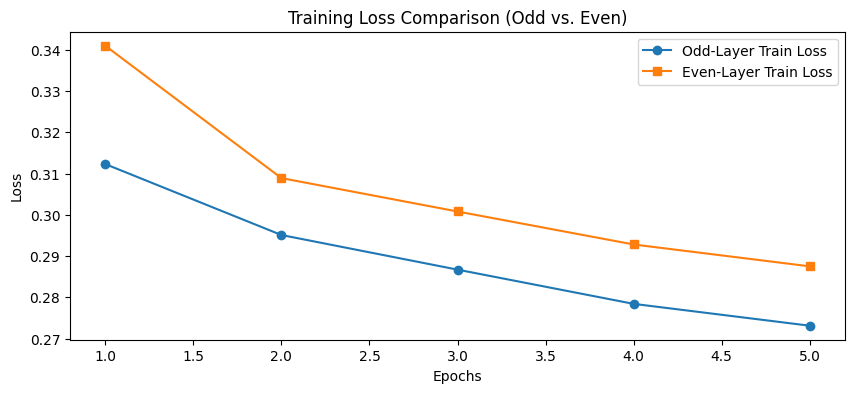

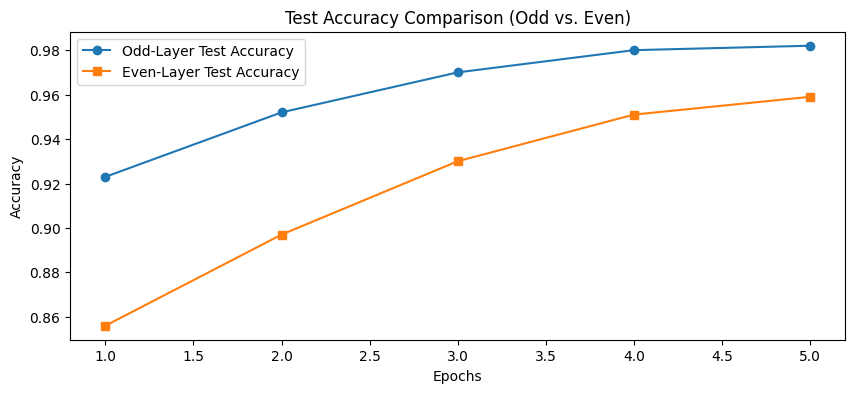

In [28]:
epochs = list(range(1, 6))

# Loss Trend
plt.figure(figsize=(10,4))
plt.plot(epochs, [0.3123, 0.2951, 0.2867, 0.2784, 0.2731], label="Odd-Layer Train Loss", marker="o")
plt.plot(epochs, [0.3410, 0.3089, 0.3008, 0.2928, 0.2875], label="Even-Layer Train Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (Odd vs. Even)")
plt.legend()
plt.show()

# Accuracy Trend
plt.figure(figsize=(10,4))
plt.plot(epochs, [0.9230, 0.9520, 0.9700, 0.9800, 0.9820], label="Odd-Layer Test Accuracy", marker="o")
plt.plot(epochs, [0.8560, 0.8970, 0.9300, 0.9510, 0.9590], label="Even-Layer Test Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Comparison (Odd vs. Even)")
plt.legend()
plt.show()

## 3. LORA Implementation on BERT
We will add LoRA to attention layers, and train again on student 12 layers with LoRA adapters

#### Load BERT + LoRA Adapter

In [29]:
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType

# Load base BERT for classification (12-layer student)
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3  # Set according to your task
)

# Define LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # Common for BERT
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

# Apply LoRA to BERT
model = get_peft_model(model, lora_config)

# Show trainable parameters
model.print_trainable_parameters()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 109,781,766 || trainable%: 0.2707


In [ ]:
# check model information, and make sure the model has 12 layers
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [30]:
#  define an accuracy metric (used by the Trainer during evaluation)
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

#### Train with Trainer

In [31]:
from transformers import TrainingArguments, Trainer

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./lora_bert_student_logs",
    per_device_train_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    learning_rate=1e-4,
    logging_dir="./logs",
    logging_steps=30,
)

# Create Trainer 
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


C:\Users\mgmgk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\mgmgk\AppData\Local\Temp\ipykernel_30484\2840323382.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.485900,0.539969,0.748000
2,0.287000,0.523579,0.776000
3,0.258700,0.525826,0.761000
4,0.219900,0.578696,0.747000
5,0.238400,0.550055,0.758000


TrainOutput(global_step=785, training_loss=0.33821232744083285, metrics={'train_runtime': 265.9552, 'train_samples_per_second': 94.001, 'train_steps_per_second': 2.952, 'total_flos': 1650165465600000.0, 'train_loss': 0.33821232744083285, 'epoch': 5.0})

####  Extract and Plot Metrics (Train Loss + Test Accuracy)

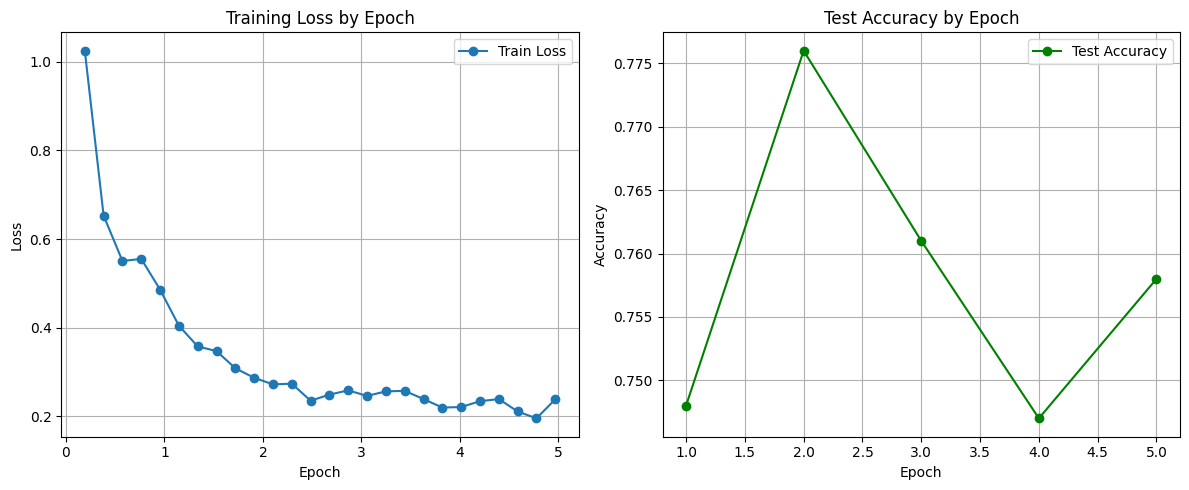

In [32]:
# Extract log history
log_history = trainer.state.log_history

# Store values per epoch
train_epochs = []
train_loss = []
eval_epochs = []
eval_accuracy = []

for log in log_history:
    if "loss" in log and "epoch" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])
    elif "eval_accuracy" in log and "epoch" in log:
        eval_epochs.append(log["epoch"])
        eval_accuracy.append(log["eval_accuracy"])

# Plotting
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, marker='o', label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss by Epoch")
plt.grid(True)
plt.legend()

# Evaluation accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracy, marker='o', color='green', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy by Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
# Save model and tokenizer for later use
model.save_pretrained("lora_bert")
tokenizer.save_pretrained("lora_bert")


('lora_bert\\tokenizer_config.json',
 'lora_bert\\special_tokens_map.json',
 'lora_bert\\vocab.txt',
 'lora_bert\\added_tokens.json',
 'lora_bert\\tokenizer.json')

### 5. Testing Functionality

#### Load Trained Model and Tokenizer Back

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

# Load tokenizer and base model
model_path = "lora_bert"  # or your custom path

tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load base model (PEFT-aware)
base_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model = PeftModel.from_pretrained(base_model, model_path)

# Set to eval mode
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [35]:
# Define Labels again from the dataset
#label_list = ["hate_speech", "offensive_language", "neither"]
label_list = ["non_hate_speech", "hate_speech", "neither"]

#### Predict Function for a Single Text

In [36]:
import torch
import torch.nn.functional as F

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()

    return {
        "text": text,
        "predicted_label": label_list[predicted_class],
        "probabilities": {label_list[i]: round(p.item(), 3) for i, p in enumerate(probs[0])}
    }



#### Example Usages

In [37]:
text = "These people are disgusting and should be deported."
result = predict(text)
print(result)


{'text': 'These people are disgusting and should be deported.', 'predicted_label': 'hate_speech', 'probabilities': {'non_hate_speech': 0.032, 'hate_speech': 0.966, 'neither': 0.002}}


In [ ]:
text = "yall hire colored folk only work half da day and throw da mail in da sewer if we aint done"
result = predict(text)
print(result) 

{'text': 'yall hire colored folk only work half da day and throw da mail in da sewer if we aint done', 'predicted_label': 'hate_speech', 'probabilities': {'non_hate_speech': 0.081, 'hate_speech': 0.917, 'neither': 0.002}}


In [39]:
text = "they need to stop picking up ufcs trash though and build up there own fighters more"
result = predict(text)
print(result)

{'text': 'they need to stop picking up ufcs trash though and build up there own fighters more', 'predicted_label': 'non_hate_speech', 'probabilities': {'non_hate_speech': 0.938, 'hate_speech': 0.061, 'neither': 0.001}}


In [40]:
text = "the sunset from my house is beautiful"
result = predict(text)
print(result)

{'text': 'the sunset from my house is beautiful', 'predicted_label': 'non_hate_speech', 'probabilities': {'non_hate_speech': 0.978, 'hate_speech': 0.021, 'neither': 0.001}}
